In [1]:
%load_ext autoreload
%autoreload 2

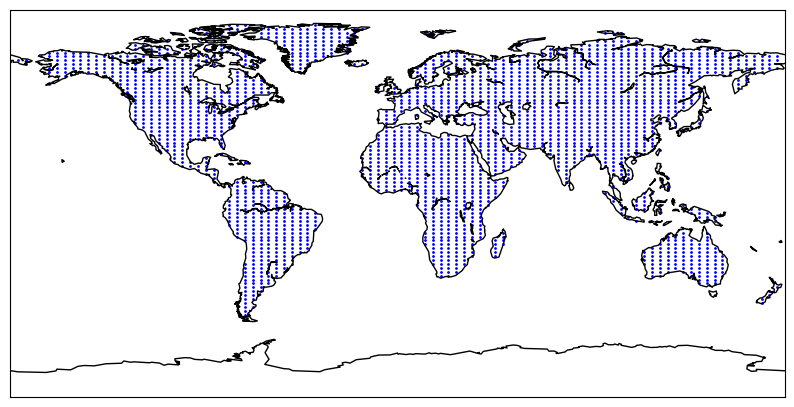

In [8]:
# Using geospatial data to generate a "land vs water" classification task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import embedders

from mpl_toolkits.basemap import Basemap

# Generate a dataset of (longitude, latitude, land/water) tuples
# 1. Generate a grid of points
_x = np.linspace(-180, 180, 100)
_y = np.linspace(-90, 90, 100)
xx, yy = np.meshgrid(_x, _y)
xx = xx.flatten()
yy = yy.flatten()

# 2. Convert to projection coordinates
m = Basemap()
mxx, myy = m(xx, yy)

# 3. Classify each point as land or water
land = np.array([m.is_land(x, y) for x, y in zip(xx, yy)])

# 4. Plot
plt.figure(figsize=(10, 10))
m.drawcoastlines()
m.scatter(xx[land], yy[land], c="blue", s=1)

In [9]:
# Generate a dataset

# 1. Convert grid to radians
xx = np.radians(xx)
yy = np.radians(yy)

# 2. Convert radians to 3D coordinates
x = np.cos(yy) * np.cos(xx)
y = np.cos(yy) * np.sin(xx)
z = np.sin(yy)
X = np.stack([x, y, z], axis=1)

# 3. Convert land labels to 0/1
y = land.astype(float)

In [237]:
# Benchmark
N_TRIALS = 100
N_SAMPLES = 1_000
MAX_DEPTH = 3
N_FEATURES = "d_choose_2"

pm = embedders.manifolds.ProductManifold([(1, 2)])

results = []
for trial in range(N_TRIALS):
    idx = np.random.choice(len(X), N_SAMPLES, replace=False)
    res = embedders.benchmarks.benchmark(
        X[idx], y[idx], pm=pm, task="classification", seed=trial, max_depth=MAX_DEPTH, n_features=N_FEATURES
    )
    res["trial"] = trial
    results.append(res)

results = pd.DataFrame(results)

In [238]:
results.mean()

sklearn_dt        0.81235
sklearn_rf        0.83535
product_dt        0.83465
product_rf        0.84230
tangent_dt        0.79665
tangent_rf        0.81830
knn               0.91380
ps_perceptron     0.70555
trial            49.50000
dtype: float64

In [239]:
results.to_csv("../data/results/land_vs_water.tsv", index=False, sep="\t")

# Run this part!

In [132]:
# Visualization
import torch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

N_POINTS = 200

pm = embedders.manifolds.ProductManifold([(1, 2)])

# 1. Get your inputs, again
_x = np.linspace(-180, 180, N_POINTS)
_y = np.linspace(-90, 90, N_POINTS)
xx, yy = np.meshgrid(_x, _y)
xx = xx.flatten()
yy = yy.flatten()

# 2. Convert to projection coordinates
m = Basemap()
mxx, myy = m(xx, yy)

# 3. Convert grid to radians
xx_rads = np.radians(xx).flatten()
yy_rads = np.radians(yy).flatten()
X = np.stack(
    [
        np.cos(yy_rads) * np.cos(xx_rads),
        np.cos(yy_rads) * np.sin(xx_rads),
        np.sin(yy_rads),
    ],
    axis=1,
)

# 4. Get y vals
y = np.array([m.is_land(x, y) for x, y in zip(mxx, myy)]).astype(float)

In [256]:
MAX_DEPTH = 3
N_FEATURES = "d_choose_2"
SEED = 2
SUBSAMPLE = 1_000

# 0. Set seeds
np.random.seed(SEED)
torch.manual_seed(SEED)

# 5. Train-test split
idx = np.random.choice(len(X), SUBSAMPLE, replace=False)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X[idx], y[idx], idx, test_size=0.2)

# 6. Predict
# pdt = embedders.tree_new.ProductSpaceDT(pm=pm, max_depth=MAX_DEPTH, task="classification", n_features=N_FEATURES)
pdt = embedders.tree_new.ProductSpaceRF(
    pm=pm, max_depth=MAX_DEPTH, task="classification", n_features=N_FEATURES, n_estimators=12
)
pdt.fit(X_train, y_train)
pdt_score = (pdt.predict(X_test).numpy() == y_test).astype(float).mean()
print(pdt_score)

# dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=12)
dt.fit(X_train, y_train)
dt_score = (dt.predict(X_test) == y_test).astype(float).mean()
print(dt_score)

X_log_train = pm.logmap(torch.tensor(X_train)).detach().numpy()
X_log_test = pm.logmap(torch.tensor(X_test)).detach().numpy()
tdt = RandomForestClassifier(max_depth=MAX_DEPTH)
tdt.fit(X_log_train, y_train)
tdt_score = (tdt.predict(X_log_test) == y_test).astype(float).mean()
print(tdt_score)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_score = (knn.predict(X_test) == y_test).astype(float).mean()
print(f"kNeighbors\t{knn_score:.4f}")

0.845
0.83
0.785
kNeighbors	0.9250


In [257]:
# Get predictions

y_pred = []
for x in tqdm(range(0, len(X), 1000)):
    y_pred.append(pdt.predict_proba(X[x : x + 1000]).numpy())
y_pred = np.concatenate(y_pred)

y_pred_dt = dt.predict_proba(X)

y_pred_tdt = tdt.predict_proba(pm.logmap(torch.tensor(X)).detach().numpy())

y_pred_knn = knn.predict_proba(X)

  0%|          | 0/40 [00:00<?, ?it/s]

/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_27729/4233986619.py:66: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x3758b0970>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_27729/4233986619.py:66: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x374ca13f0>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_27729/4233986619.py:66: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x374895d20>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_27729/4233986619.py:66: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x374cadff0>' will be ignored
  coll.set_rasterized(True)
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_27729/4233986619.py:78: UserWarning: This figure includes Axes that are n

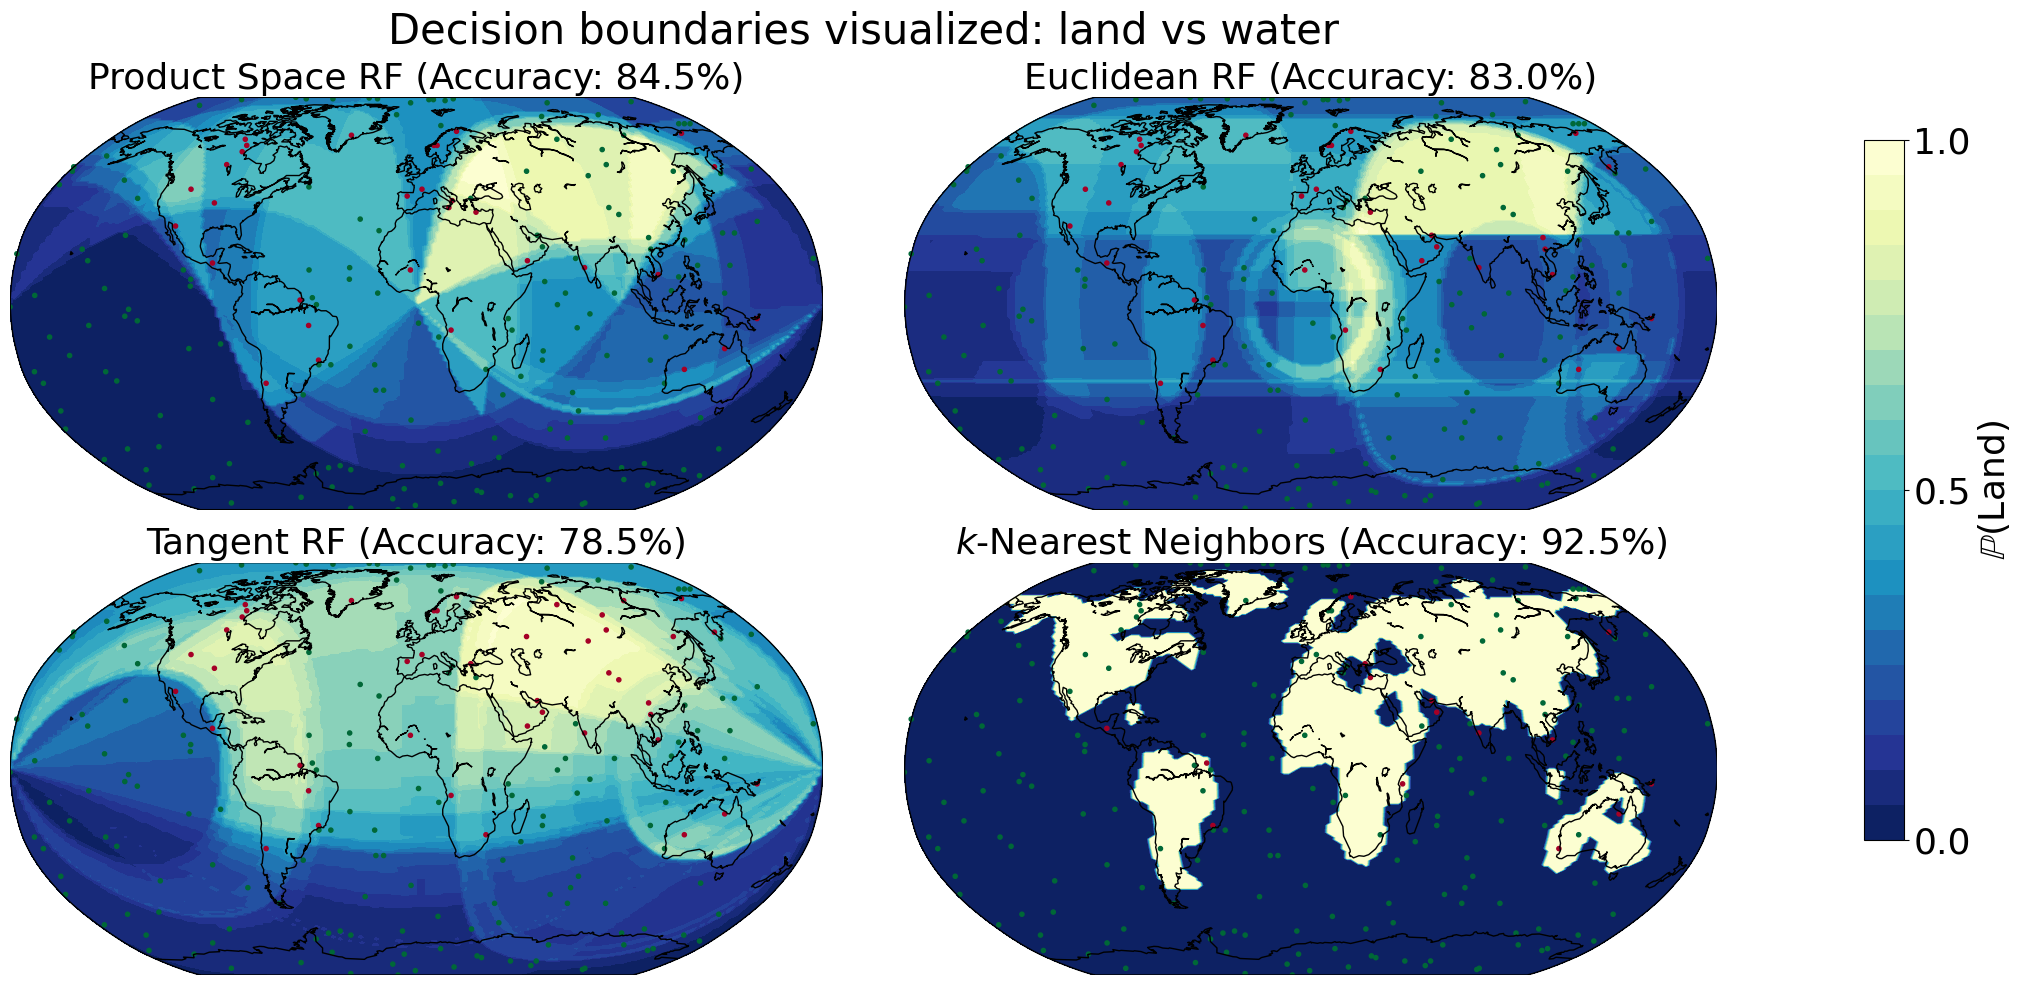

In [258]:
# 7. Plot
ALPHA = 1
LEVELS = 20
CMAP_MAP = "YlGnBu_r"


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

m2 = Basemap(projection="robin", lon_0=0, lat_0=0, resolution="c")
test_x_vals, test_y_vals = m2(xx[idx_test], yy[idx_test])
mxx2, myy2 = m2(xx, yy)

axs[0, 0].contourf(
    mxx2.reshape(N_POINTS, N_POINTS),
    myy2.reshape(N_POINTS, N_POINTS),
    y_pred[:, 1].reshape(N_POINTS, N_POINTS),
    cmap=CMAP_MAP,
    alpha=ALPHA,
    levels=LEVELS,
)
axs[0, 0].set_title(f"Product Space RF (Accuracy: {pdt_score * 100:.1f}%)", fontsize=26)
axs[0, 0].scatter(test_x_vals, test_y_vals, c=(y_pred[idx_test].argmax(axis=1) == y[idx_test]), s=9, cmap="RdYlGn")

axs[0, 1].contourf(
    mxx2.reshape(N_POINTS, N_POINTS),
    myy2.reshape(N_POINTS, N_POINTS),
    y_pred_dt[:, 1].reshape(N_POINTS, N_POINTS),
    cmap=CMAP_MAP,
    alpha=ALPHA,
    levels=LEVELS,
)
axs[0, 1].set_title(f"Euclidean RF (Accuracy: {dt_score * 100:.1f}%)", fontsize=26)
axs[0, 1].scatter(test_x_vals, test_y_vals, c=(y_pred_dt[idx_test].argmax(axis=1) == y[idx_test]), s=9, cmap="RdYlGn")

axs[1, 0].contourf(
    mxx2.reshape(N_POINTS, N_POINTS),
    myy2.reshape(N_POINTS, N_POINTS),
    y_pred_tdt[:, 1].reshape(N_POINTS, N_POINTS),
    cmap=CMAP_MAP,
    alpha=ALPHA,
    levels=LEVELS,
)
axs[1, 0].set_title(f"Tangent RF (Accuracy: {tdt_score * 100:.1f}%)", fontsize=26)
axs[1, 0].scatter(test_x_vals, test_y_vals, c=(y_pred_tdt[idx_test].argmax(axis=1) == y[idx_test]), s=9, cmap="RdYlGn")

axs[1, 1].contourf(
    mxx2.reshape(N_POINTS, N_POINTS),
    myy2.reshape(N_POINTS, N_POINTS),
    y_pred_knn[:, 1].reshape(N_POINTS, N_POINTS),
    cmap=CMAP_MAP,
    alpha=ALPHA,
    levels=LEVELS,
)
axs[1, 1].set_title(f"$k$-Nearest Neighbors (Accuracy: {knn_score * 100:.1f}%)", fontsize=26)
axs[1, 1].scatter(test_x_vals, test_y_vals, c=(y_pred_knn[idx_test].argmax(axis=1) == y[idx_test]), s=9, cmap="RdYlGn")

# Cleanup
for ax in axs.flatten():
    m2.drawcoastlines(ax=ax)
    # Ticks off
    ax.set_xticks([])
    ax.set_yticks([])

    # Rasterize contour plots
    for coll in ax.collections:
        coll.set_rasterized(True)

# Colorbar
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
# Colorbar with font size 20
fig.colorbar(axs[1, 1].collections[0], cax=cbar_ax, orientation="vertical", label="$\mathbb{P}(\\text{Land})$", ticks=[0, 0.5, 1])
cbar_ax.tick_params(labelsize=26)
# Also the label should be larger
cbar_ax.yaxis.label.set_size(26)

plt.suptitle("Decision boundaries visualized: land vs water", fontsize=30)
plt.tight_layout()

# Save
plt.savefig("../figures/land_vs_water.pdf", bbox_inches="tight", dpi=300)